<a href="https://colab.research.google.com/github/syadri/Multivariate-Time-Series-Forecasting-with-LSTMs/blob/main/Predict_Wind_Power_Output_with_Keras_(LSTM).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget https://s3.us-west-1.wasabisys.com/mdason-datasets/Turbine_Data.csv.zip

In [ ]:
!unzip /content/Turbine_Data.csv.zip

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
from pandas import read_csv
from pandas import datetime
import pandas as pd
import missingno as msno
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt
import numpy as np
import matplotlib.pyplot as plt, seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

In [ ]:

from numpy.random import randn
import os
import random
import numpy as np
import time

# load dataset
series = pd.read_csv("/content/Turbine_Data.csv")

In [ ]:
msno.matrix(series)

In [ ]:
plt.subplots(figsize=(16, 16))
sns.heatmap(series.corr(), annot=True, square=True)
plt.show()

In [ ]:
df_selected = series[['Unnamed: 0','ActivePower','WindSpeed']]

In [ ]:
print(df_selected.head())
#end of dataset is 2020-03-30 23:50:00+00:00 
print(df_selected.tail())

In [ ]:
input_df = df_selected[['ActivePower', 'WindSpeed']]
rng = pd.date_range('2017-12-31', periods=118224, freq='10T')
time_df = pd.DataFrame(rng)
input_df = input_df.fillna(0).astype(float)
input_df = pd.concat((time_df, input_df), axis=1)
input_df = input_df.set_index(0)
input_df = input_df.loc['2019-12-17':]
input_df.head()

In [ ]:
input_df.isna().sum()

In [ ]:
# split data into train and test, for baseline we only need the Y target = "ActivePower" feature
X = input_df['ActivePower'].values
train, test = X[0:-144], X[-144:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
	# make prediction
	predictions.append(history[-144])
	# observation
	history.append(test[i])
# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)
# line plot of observed vs predicted
plt.figure(figsize=(15, 8))
plt.title('Predicted vs Actual Power Baseline')
plt.plot(test, color='C0', marker='o', label='Actual Power')
plt.plot(predictions, color='C1', marker='o', label='Predicted Power')
plt.legend()
plt.savefig('example.png')
plt.show()

In [ ]:
def forecast_accuracy(forecast, actual):
    forecast = np.array(forecast)
    actual = np.array(actual)
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 
            'corr':corr, 'minmax':minmax})

In [ ]:
t = pd.DataFrame(test)
c = pd.DataFrame(predictions)
forecast_accuracy(c, t)

In [ ]:
def create_X_Y(ts: np.array, lag=1, n_ahead=1, target_index=0) -> tuple:
    """
    A method to create X and Y matrix from a time series array for the training of 
    deep learning models 
    """
    # Extracting the number of features that are passed from the array 
    n_features = ts.shape[1]
    
    # Creating placeholder lists
    X, Y = [], []

    if len(ts) - lag <= 0:
        X.append(ts)
    else:
        for i in range(len(ts) - lag - n_ahead):
            Y.append(ts[(i + lag):(i + lag + n_ahead), target_index])
            X.append(ts[i:(i + lag)])

    X, Y = np.array(X), np.array(Y)

    # Reshaping the X array to an LSTM input shape 
    X = np.reshape(X, (X.shape[0], lag, n_features))

    return X, Y

In [ ]:
lag = 360
# Steps in future to forecast (steps in 10min intervals)
n_ahead = 144
# ratio of observations for training from total series
train_share = 0.8
# training epochs
epochs = 20
# Batch size , which is the number of samples of lags
batch_size = 512
# Learning rate
lr = 0.001
# The features for the modeling 
features_final = ['ActivePower','WindSpeed']

In [ ]:
# Subseting only the needed columns 
ts = input_df[features_final]

In [ ]:
#Scaling data between 0 and 1
scaler = MinMaxScaler()
scaler.fit(ts)
ts_scaled = scaler.transform(ts)

In [ ]:
# Creating the X and Y for training, the formula is set up to assume the target Y is the left most column = target_index=0
X, Y = create_X_Y(ts_scaled, lag=lag, n_ahead=n_ahead)

In [ ]:
# Spliting into train and test sets 
Xtrain, Ytrain = X[0:int(X.shape[0] * train_share)], Y[0:int(X.shape[0] * train_share)]
Xtest, Ytest = X[int(X.shape[0] * train_share):], Y[int(X.shape[0] * train_share):]

In [ ]:
#Neural Network Model configuration, this is a Vanilla LSTM model
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(16, activation='relu', return_sequences=False))
#model.add(tf.keras.layers.CuDNNLSTM(32, return_sequences=False)) you can try to use the 10x faster GPU accelerated CuDNNLSTM instaed of the Vanilla LSTM above, but do not forget to set up the notebook accelerator to "GPU"
model.add(tf.keras.layers.Dense(144))

#set up early stop function to stop training when val_loss difference is higher than 0.001
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, min_delta=0.001)
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001), loss='mae', metrics='mae')

Epoch 1/20
366/366 [==============================] - 45s 117ms/step - loss: 0.2410 - mae: 0.2410 - val_loss: 0.2417 - val_mae: 0.2417
Epoch 2/20
366/366 [==============================] - 43s 117ms/step - loss: 0.2103 - mae: 0.2103 - val_loss: 0.2377 - val_mae: 0.2377
Epoch 3/20
366/366 [==============================] - 45s 123ms/step - loss: 0.2067 - mae: 0.2067 - val_loss: 0.2330 - val_mae: 0.2330
Epoch 4/20
366/366 [==============================] - 44s 121ms/step - loss: 0.2030 - mae: 0.2030 - val_loss: 0.2356 - val_mae: 0.2356
Epoch 5/20
366/366 [==============================] - 44s 120ms/step - loss: 0.1999 - mae: 0.1999 - val_loss: 0.2230 - val_mae: 0.2230
Epoch 6/20
366/366 [==============================] - 43s 118ms/step - loss: 0.1980 - mae: 0.1980 - val_loss: 0.2191 - val_mae: 0.2191
Epoch 7/20
366/366 [==============================] - 44s 119ms/step - loss: 0.1953 - mae: 0.1953 - val_loss: 0.2139 - val_mae: 0.2139
Epoch 8/20
366/366 [==============================] - 4

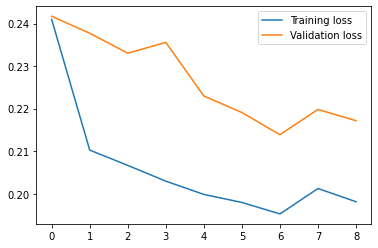

In [24]:
#Train model on train data and use test data for validation
#If the model does not converge accurately, you need check if it is a input data quality issue, introduce a dropout layer, or you can try adjusting the number of hidden nodes
history = model.fit(Xtrain, Ytrain,epochs=epochs, validation_data=(Xtest, Ytest), shuffle=False, callbacks=[early_stopping])
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label = 'Validation loss')
plt.legend()

In [25]:
yhat = model.predict(Xtest)

In [28]:
days = time_df.values[-len(yhat):-len(yhat) + n_ahead]
days_df = pd.DataFrame(days)

In [26]:
#prepare resulting series for inverse scaling transformation
#pay attention we will select only the first prediction we have made, therefore [0] used to select this window (we have generated multiple prediction sequences of 144 steps ahead, starting from each interval step in the test dataset)
pred_n_ahead = pd.DataFrame(yhat[0])
actual_n_ahead = pd.DataFrame(Ytest[0])

#repeat the column series 2 times, to make shape compatible for scale inversion
pr_p = pd.concat([pred_n_ahead]*2, axis=1)
ac_p = pd.concat([actual_n_ahead]*2, axis=1)

In [29]:
#inverse scale tranform the series back to kiloWatts of power
pr_p = pd.DataFrame(scaler.inverse_transform(pr_p))
ac_p = pd.DataFrame(scaler.inverse_transform(ac_p))

#rename columns
pr_p = pr_p.rename(columns={0:'PredPower'})
ac_p = ac_p.rename(columns={0:'ActualPower'})

#concatenate together into one dataframe and set index
df_final = pd.concat([days_df, pr_p['PredPower'], ac_p['ActualPower']], axis=1).set_index(0)

<function matplotlib.pyplot.show(*args, **kw)>

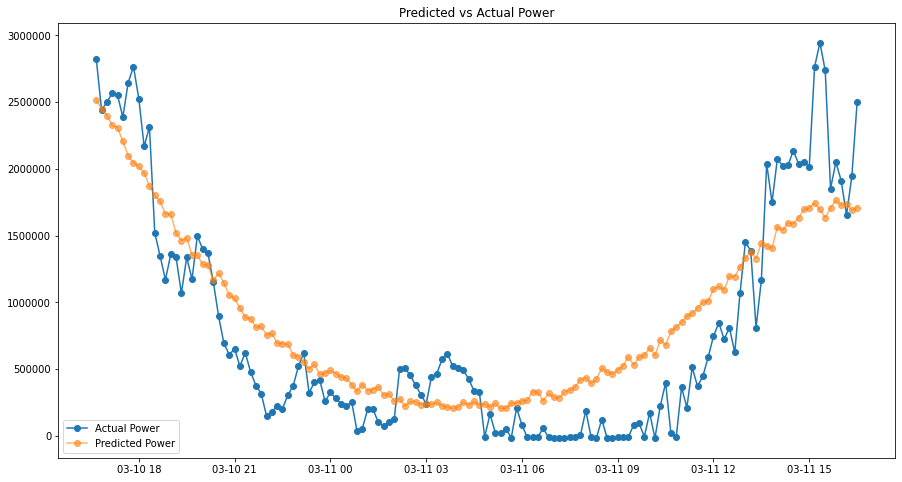

In [30]:
#plot n_steps ahead for predicted and actual data
plt.figure(figsize=(15, 8))
plt.plot(df_final.index, df_final.ActualPower, color='C0', marker='o', label='Actual Power')
plt.plot(df_final.index, df_final.PredPower, color='C1', marker='o', label='Predicted Power', alpha=0.6)
plt.title('Predicted vs Actual Power')
plt.gcf().axes[0].yaxis.get_major_formatter().set_scientific(False)
plt.legend()
plt.savefig('forecast_example.png')
plt.show